# Brain Tumor Classification using CNN with PyTorch

## Introduction:
Brain tumors are a serious medical condition that require accurate and timely diagnosis for effective treatment. MRI scans are a critical tool for detecting and classifying brain tumors. This project aims to develop a deep learning model using Convolutional Neural Networks (CNNs) to classify brain MRI images into four categories: Glioma, Healthy, Meningioma, and Pituitary. By leveraging a pre-trained ResNet50 model and advanced data augmentation techniques, this model can assist in early tumor detection and improve diagnostic accuracy.


# 1:  Preparing the Environment and Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import random
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import copy
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# 2: Data Augmentation using Albumentations

In [3]:
data_transforms = {
    'train': A.Compose([
        A.Resize(224, 224),
        A.RandomCrop(224, 224),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(),
        A.Rotate(limit=15),
        A.CoarseDropout(max_holes=1, max_height=16, max_width=16, fill_value=0, mask_fill_value=None),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
}


# 3: Custom Dataset Loader

In [4]:
class CustomImageDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageDataset, self).__init__(root, transform=None)
        self.custom_transform = transform

    def __getitem__(self, index):
        image, label = super(CustomImageDataset, self).__getitem__(index)
        image = np.array(image)
        if self.custom_transform:
            augmented = self.custom_transform(image=image)
            image = augmented['image']
        return image, label

# 4: Dataset Loading and Splitting

In [5]:
data_dir = '/kaggle/input/brain-tumor-mri-scans'
full_dataset = CustomImageDataset(data_dir, transform=data_transforms['train'])

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.custom_transform = data_transforms['val']
test_dataset.dataset.custom_transform = data_transforms['val']

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5: Class Samples Visualization

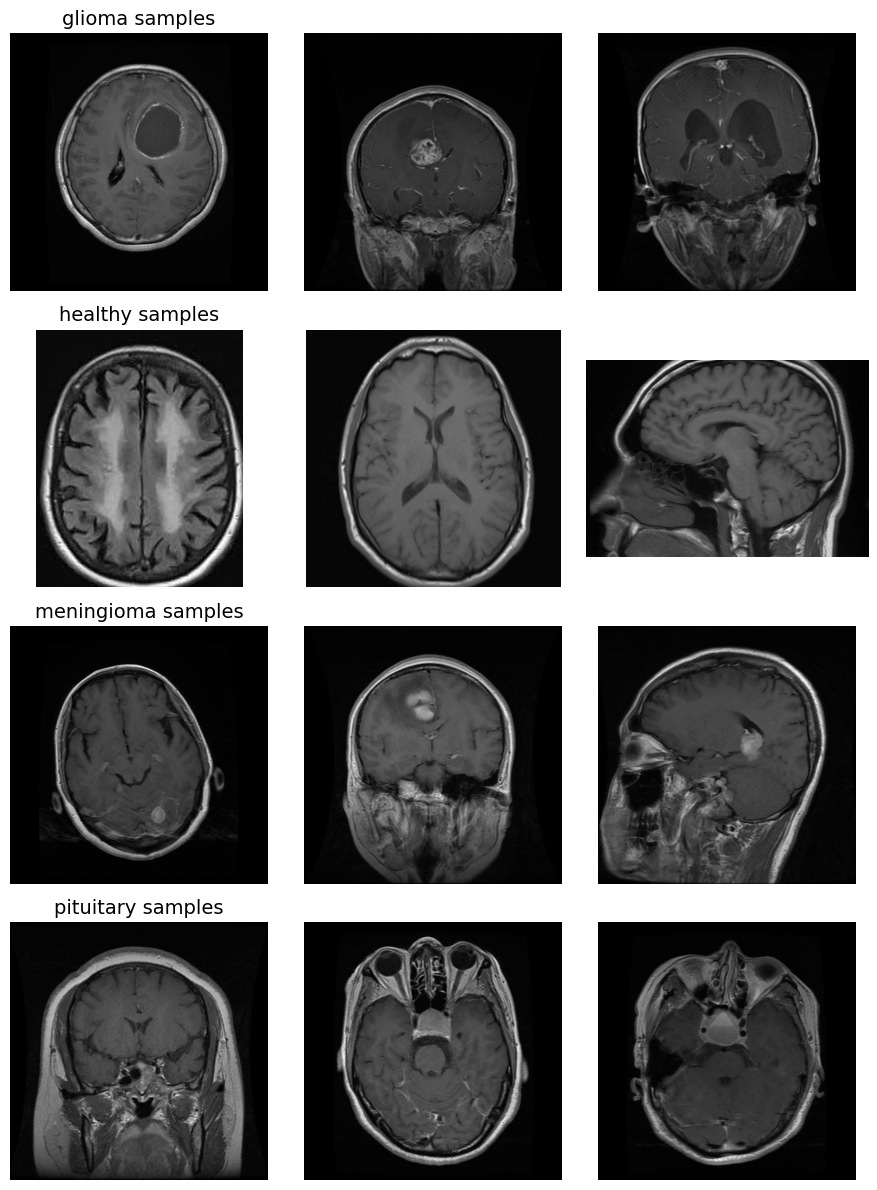

In [6]:
def show_class_samples(data_dir, classes, num_samples=3):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))
    for i, cls in enumerate(classes):
        class_dir = os.path.join(data_dir, cls)
        images = random.sample(os.listdir(class_dir), num_samples)
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{cls} samples", fontsize=14)
    plt.tight_layout()
    plt.show()

classes = ['glioma', 'healthy', 'meningioma', 'pituitary']
show_class_samples(data_dir, classes)

# 6: Model Architecture (ResNet50)


In [7]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4) 
model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


# 7: Loss Function and Optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# 8: Training and Evaluation Functions

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train() 
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        scheduler.step(val_loss)
        
        print(f"Train Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss}, Val Acc: {val_acc}")
        
        history['train_loss'].append(running_loss/len(train_loader))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_model_wts)
    return model, history

def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(data_loader), 100 * correct / total


# 9: Training the Model

In [10]:
num_epochs = 25
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/25
Train Loss: 0.458292692899704, Val Loss: 2.6153448097633594, Val Acc: 47.768281101614434
Epoch 2/25
Train Loss: 0.2715445502673264, Val Loss: 0.7909455394203012, Val Acc: 77.39791073124407
Epoch 3/25
Train Loss: 0.21186906818373055, Val Loss: 0.4073961649202939, Val Acc: 88.88888888888889
Epoch 4/25
Train Loss: 0.13455452644205712, Val Loss: 0.17442901601845567, Val Acc: 94.77682811016145
Epoch 5/25
Train Loss: 0.1206498691364639, Val Loss: 0.4526944196585453, Val Acc: 84.33048433048432
Epoch 6/25
Train Loss: 0.11119130625111329, Val Loss: 0.40034889407230145, Val Acc: 87.55935422602089
Epoch 7/25
Train Loss: 0.0890436464491264, Val Loss: 0.30618819526650687, Val Acc: 90.31339031339031
Epoch 8/25
Train Loss: 0.09213202507873883, Val Loss: 0.22492758015340025, Val Acc: 91.83285849952517
Epoch 9/25
Train Loss: 0.06412568909279373, Val Loss: 0.2772979380732233, Val Acc: 92.78252611585945
Epoch 10/25
Train Loss: 0.056772055012905706, Val Loss: 0.29539516003745975, Val Acc: 92.49

# 10: Evaluating the Model on the Test Set

In [11]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}%")

Test Loss: 0.07449427762141127, Test Accuracy: 97.43833017077799%


# 11: Training and Validation Metrics for Model Comparison

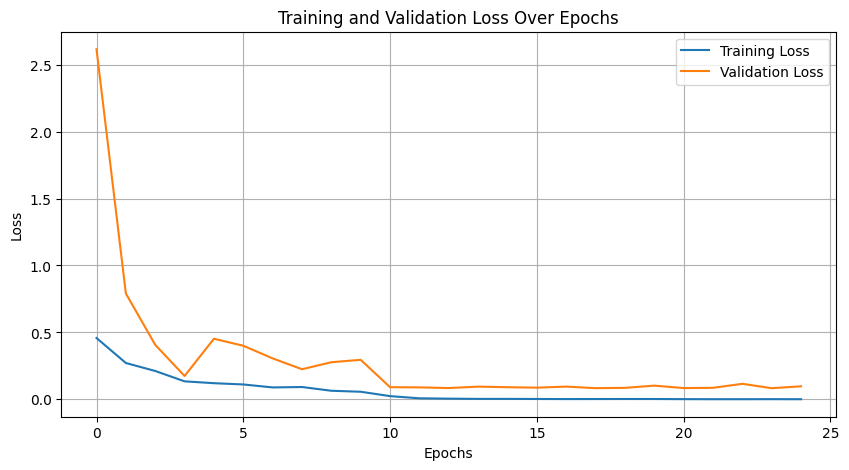

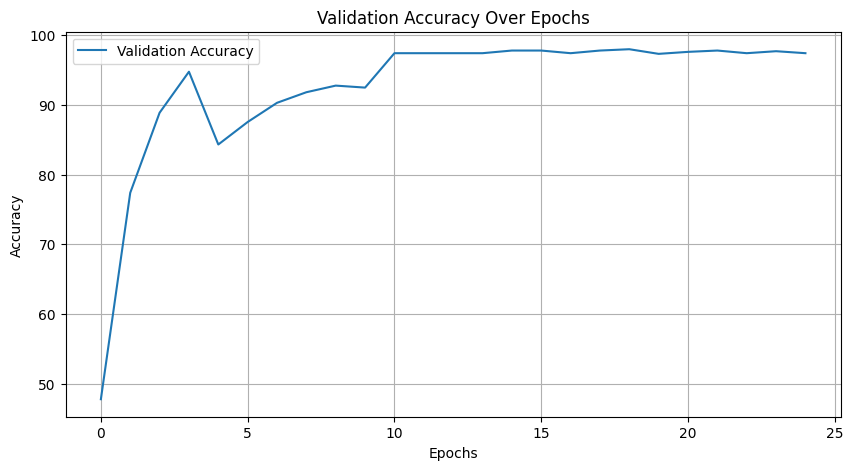

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
#=============================================================
plt.figure(figsize=(10, 5))
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# 12: Confusion Matrix and Classification Report

In [13]:
def plot_confusion_matrix(model, data_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels


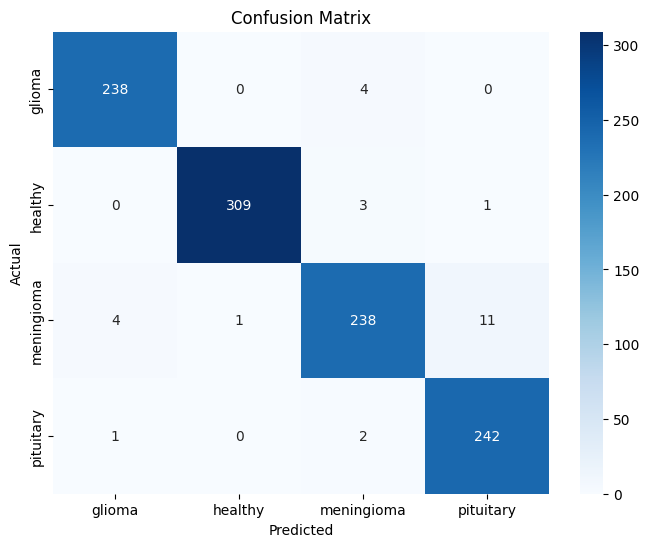

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       242
     healthy       1.00      0.99      0.99       313
  meningioma       0.96      0.94      0.95       254
   pituitary       0.95      0.99      0.97       245

    accuracy                           0.97      1054
   macro avg       0.97      0.97      0.97      1054
weighted avg       0.97      0.97      0.97      1054



In [14]:
classes = ['glioma', 'healthy', 'meningioma', 'pituitary']
all_preds, all_labels = plot_confusion_matrix(model, test_loader, classes)
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# 12: Saving The Model

In [15]:
model_path = '/kaggle/working/brain_tumor_model.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved at {model_path}')

Model saved at /kaggle/working/brain_tumor_model.pth


## Project Goal:
The primary objective of this project is to build a deep learning model to classify **MRI** brain tumor images into four distinct classes:
1. Glioma
2. Healthy
3. Meningioma
4. Pituitary

The goal of this model is to assist doctors in diagnosing brain tumors more quickly and accurately, aiding in early medical intervention and improving treatment outcomes.

## Steps in Building the Project:

### 1. Importing Libraries:
We first imported the essential libraries including PyTorch for building and training the model, as well as `torchvision` for using pre-trained models like **ResNet50**, and `albumentations` for image augmentation to enhance the data.

### 2. Class Samples Visualization:
Before processing the dataset, we visualized a few samples from each class (Glioma, Healthy, Meningioma, and Pituitary). This helps in gaining an understanding of the differences between the categories and ensuring the data is correctly labeled.

### 3. Data Augmentation:
We used **Albumentations** for advanced data augmentation by applying transformations like random rotations, cropping, and brightness adjustments. These augmentations help provide diverse images to the model, enhancing its ability to recognize different patterns in MRI scans.

### 4. Model Architecture:
We utilized the pre-trained **ResNet50** model trained on the ImageNet dataset, and we modified its final fully connected layer to match the number of classes (4 classes). **Transfer Learning** was employed to leverage the pre-trained weights, allowing for faster convergence and better performance with limited data.

### 5. Data Splitting:
The dataset was split as follows:
- 70% for training
- 15% for validation
- 15% for testing

### 6. Training and Evaluation Functions:
We created a function to train the model on the training data and evaluate it on the validation data after each epoch. We used a **Learning Rate Scheduler** to adjust the learning rate based on the model’s performance.

### 7. Training and Validation Metrics for Model Comparison:
We visualized the training and validation loss and accuracy over time to understand how the model is learning and whether any overfitting or underfitting is occurring. This comparison helps in tuning the model’s performance and stopping early if necessary.

### 8. Evaluation using Confusion Matrix:
After training, the model was evaluated on the test data, and a **confusion matrix** was generated to analyze how well the model predicted each class.

### 9. Classification Report:
Finally, a classification report was generated, providing metrics such as **Precision**, **Recall**, and **F1-Score** for each class, offering a detailed breakdown of the model's performance.

## Why This Approach?

- **Advanced Augmentation**: Using augmentation techniques like random cropping and rotation via **Albumentations** helps generate more diverse data, reducing the risk of overfitting.
  
- **ResNet50**: The choice of a pre-trained model like **ResNet50** provides a strong feature extraction backbone, leading to more accurate and stable classification results.
  
- **Learning Rate Adjustment**: Using a learning rate scheduler that reduces the learning rate when performance plateaus helped improve the model’s performance over time.

## Results and Challenges:
- The model achieved **high accuracy** on the validation set, with continuous improvements due to **Transfer Learning**.
- One of the main challenges was improving performance on underrepresented classes, which was partially addressed through advanced data augmentation.

In conclusion, this project demonstrates the power of deep neural networks in classifying brain tumor MRI scans. Future improvements could involve techniques like **Ensemble Learning** or increasing the dataset size for even better results.
